# Introduction to Gradient Descent

Prepared by: Benjamin Ricard, QBS108 TA | Last update: 11/26/2018

### Learning Objectives

By the end of this tutorial, students should be able to:

* Understand the theory and mathematics behind Gradient Descent
* Understand the variables involved in GD (e.g. step-size, iterations)


### General Procedure

* Simulate a linear data that is known to be better approximated by first-order regression models (From Chen: Demo 1)
* Using GD, reach minimum error of prediction (MSE) for a linear regression.


In [654]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_squared_log_error, mean_absolute_error, r2_score #other metrics can be used
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
import numpy as np
import copy as cp
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

def f(x, FUN=lambda x: 15+5*x):
    '''
    Helper function to approximate data by an input function
    Parameters:
        x: 1D array
        FUN: Mathematical function of interest. Defaults to sin
    '''
    return FUN(x); 

def simulate_data(a, b, N, seed=42):
    '''
    Function to simulate non-linear data
    Parameters:
        a,b: Range/bounds
        N: Number of examples (i.e. sample size)
        seed: Random seed for shuffling
    '''
    rng = np.random.RandomState(seed); 
    x = np.linspace(a, b, N); 
    x_plot = cp.deepcopy(x);
    x = np.linspace(a, b, N); 
    rng.shuffle(x);  
    noise = np.random.normal(0, (a+b)/2, N);
    return x, f(x)+noise, x_plot, f(x_plot)+noise;

def reformat_to_matrix(x, x_plot):
    '''
    Helper function to convert data into matrix format
    Parameters:
        x, x_plot: Arrays
    '''
    X = x[:, np.newaxis]
    X_plot = x_plot[:, np.newaxis];
    return X, X_plot;

### Simulated data

In [593]:
a, b, N = 0, 100, 20;
xval, yval, x_plot, y_plot = simulate_data(a, b, N);
points=xval,yval

### Construct models and visualize

The first thing we need to do is define our error function. By definiton, the ideal model is the one with the least amount of error. We will use the mean-squared error (MSE) as our error function to minimize. This function takes the form:

$$
\frac{1}{N} \sum_i^N (y_i-\hat{y_i})^2
$$

Where N is the number of samples, $y_i$ is the true value/label for sample i, $\hat{y_i}$ is the predicted value for sample i. The error is squared to be robust to negative/positive errors. Intuitively, we can think of this as the average distance from the predicted value $\hat{y}$ to the true value $y$. The ideal model would have the smallest error, so this becomes our function to minimize.

For linear regression, our predicted probabilities take the form $\hat{y_i} = mx_i+b$, so our error function becomes;

$$
\frac{1}{N} \sum_i^N (y_i-(b+mx_i))^2
$$

The code below calculates the error function.

In [641]:
#Code modified from Siraj Raval at https://github.com/llSourcell/linear_regression_live/blob/master/demo.py
#You can train as many variables as you want (commented out) - Here we will use only 2, the intercept b and slope m

from numpy import *

# y = mx + b
# m is slope, b is y-intercept
#First computes MSE
def compute_error_for_line_given_points(b, m,points):
    totalError = 0
    for i in range(0, len(points[0])):
        x = points[0][i]
        y = points[1][i]
        totalError += (y - ((m * x) + b)) ** 2
    return totalError / float(len(points[0]))

In the simpliest case, we solve for 2 variables, b and m, that minimize the error function. To do this, we calculate the gradient w.r.t each of these varibles:


\begin{equation*}
\frac{\partial}{\partial b} \frac{1}{N} \sum_i^N (y_i-(b+mx_i))^2 = \frac{-2}{N} \sum_i^N (y_i-(b+mx_i))
\end{equation*}


\begin{equation*}
\frac{\partial}{\partial m} \frac{1}{N} \sum_i^N (y_i-(b+mx_i))^2 = \frac{-2}{N} \sum_i^N x_i(y_i-(b+mx_i))
\end{equation*}

(Note: this is extendible to any number of x variables to be used for prediction - simply calculate the partial derivative for each variable).

The idea of gradient descent is to make small steps towards the optimal variables using the gradient (derivative;direction) as a guide. Now that we have the gradient, we will make small steps in the direction that minimizes the error for each variable in our model.

For each i in the number of iterations, we can make updates to our variables b and m by simply subtracting the gradient.

For i in N iterations:
 $$b_{i+1} =b_i - \frac{\partial}{\partial b_i} $$
 and;
  $$ m_{i+1} =m_i - \frac{\partial}{\partial m_i} $$
  
Recall again that the derivative provides the direction that improves the error, but not the magnitude. We will alter our updates by scaling the gradient subtraction by a step-size/learning rate alpha, that we can tune to train our model.

For i in N iterations:
 $$ b_{i+1} =b_i - \alpha \frac{\partial}{\partial b_i} $$
 and;
  $$ m_{i+1} =m_i - \alpha \frac{\partial}{\partial m_i} $$
 
This portion is written below.

In [647]:


def step_gradient(b_current, m_current,points, learningRate):
    b_gradient = 0
    m_gradient = 0
    N = float(len(points[0]))
    for i in range(0, len(points[0])):
        x = points[0][i]
        y = points[1][i]
        b_gradient += -(2/N) * (y - ((m_current * x) + b_current))
        m_gradient += -(2/N) * x * (y - ((m_current * x) + b_current))
#        m2_gradient += -(2/N) * x**3 * (y - ((m2_current * x**3) + b_current))
#        m3_gradient += -(2/N) * x**4 * (y - ((m3_current * x**4) + b_current))
#        m4_gradient += -(2|/N) * x**5 * (y - ((m4_current * x**5) + b_current))
#        m5_gradient += -(2/N) * x**6 * (y - ((m5_current * x**6) + b_current))
    new_b = b_current - (learningRate * b_gradient)
    new_m = m_current - (learningRate * m_gradient)
#    new_m2 = m2_current - (learningRate * m2_gradient)
#    new_m3 = m3_current - (learningRate * m3_gradient)
#    new_m4 = m4_current - (learningRate * m4_gradient)
#    new_m5 = m5_current - (learningRate * m5_gradient)
    return [new_b, new_m]

Finally, we can loop over step_gradient to run our GD. As a rule, GD is very sensitive to learning rate and requires careful training. Too small a learning rate will not train in a feasible time, and too large a learning rate can cause erratic behavoir and divergence. 

In [650]:

def gradient_descent_runner(points, starting_b, starting_m, learning_rate, num_iterations):
    b = starting_b
    m = starting_m
    for i in range(num_iterations):
        err1=compute_error_for_line_given_points(b,m,points)
        b, m = step_gradient(b, m, array(points), learning_rate)
        err2=compute_error_for_line_given_points(b,m,points)
        if err1<err2:
            print(i)
            break
    return [b, m]

def run(points,num_iterations):
    learning_rate = .00001
    initial_b = 0 # initial y-intercept guess
    initial_m= 0 # initial slope guess
    print("Starting gradient descent at b = {0}, m = {1}, error = {2}".format(initial_b, initial_m, compute_error_for_line_given_points(initial_b, initial_m,points)))
    print("Running...")
    [b, m] = gradient_descent_runner(points, initial_b, initial_m,learning_rate, num_iterations)
    print("After {0} iterations b = {1}, m = {2}, error = {3}".format(num_iterations, b, m, compute_error_for_line_given_points(b, m, points)))
    return [b,m]


First, just run 1 iteration to see initial behavior. Notice the initial and final errors.

Starting gradient descent at b = 0, m = 0, error = 96473.36018715879
Running...
After 1 iterations b = 0.005148141334870933, m = 0.3577799528093703, error = 84108.16156001156


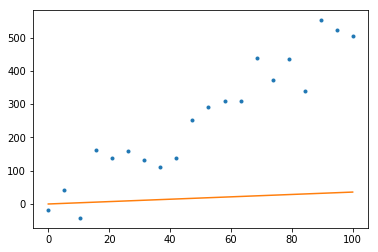

In [651]:
b,m = run(points,1)
plt.plot(xval, yval, '.')

x_plot = np.linspace(0,max(xval),100)
plt.plot(x_plot,((m * x_plot) + b), '-')
plt.show()

We see that after the first update we are still far away from the ideal b and m values. We'll try to run with 10 iterative updates now.

Starting gradient descent at b = 0, m = 0, error = 96473.36018715879
Running...
After 10 iterations b = 0.03799105463899551, m = 2.6548462611973953, error = 25591.105155260226


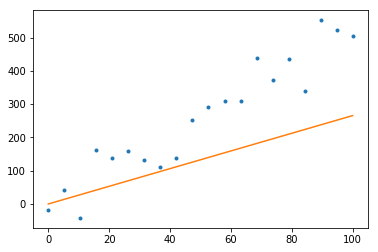

In [652]:
b,m = run(points,10)
plt.plot(xval, yval, '.')

x_plot = np.linspace(0,max(xval),100)
plt.plot(x_plot,((m * x_plot) + b), '-')
plt.show()

Much better. We will now try to run for 100 updates.

Starting gradient descent at b = 0, m = 0, error = 96473.36018715879
Running...
After 100 iterations b = 0.06821860384489266, m = 5.2237149651234205, error = 2930.771674941734


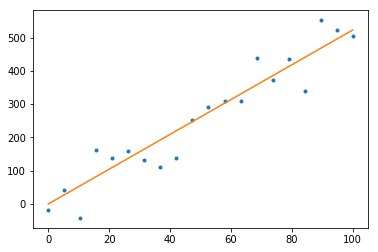

In [653]:

b,m = run(points,100)
plt.plot(xval, yval, '.')

x_plot = np.linspace(0,max(xval),100)
plt.plot(x_plot,((m * x_plot) + b), '-')
plt.show()

Success! Our gradient descent helped us find good choices of variables.